# Intro to AI in Pytorch

In this notebook we will explore the basics of doing classification with PyTorch.

First thing we want to demonstrate is that PyTorch can make performing GPU computations very easy. If the GPU is available, using the GPU for matrix multiplication is very easy.

In [1]:
from datetime import datetime
import numpy as np
import torch

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

N = int(1e4)
A_cpu = torch.rand(N, N)

# start_time = datetime.now()
# A_cpu @ A_cpu
# print(f"Total time: {datetime.now() - start_time}")

# A_gpu = A_cpu.to(device)
# start_time = datetime.now()
# A_gpu @ A_gpu
# print(f"Total time: {datetime.now() - start_time}")

In [2]:
device

'cpu'

We now turn to deep learning. We first create a classification problem. In this dataset, each spiral arm is of a different class.

In [170]:
import random

import math
from IPython import display
from matplotlib import pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset




## Linear Data

In [235]:
N = 1000  # num_samples_per_class
D = 1  # dimensions
 
tensor = torch.ones((N,D), dtype=torch.float32)
k = tensor.new_full((N,D),random.random())
b = 0.08 * torch.randn((N,D),dtype=torch.float32)
x = torch.randn((N,D),dtype=torch.float32)
print(tuple(y.size()), tuple(b.size()))
y = k*x+b


(1000, 1) (1000, 1)


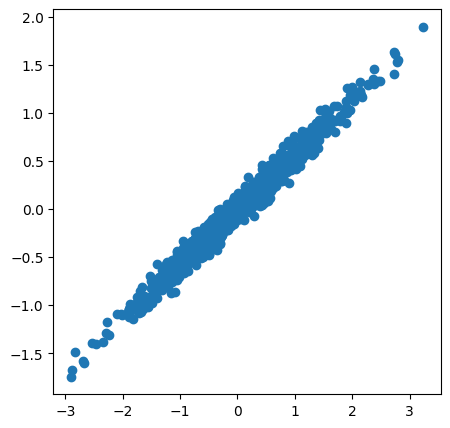

In [236]:
plt.scatter(x,y)

In [237]:
batchsize = 100
dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset,batch_size=batchsize)

## Linear Regression

The below function encapsulates the training procedure for an epoch (single run over the entire training dataset)

In [253]:
class LinearRegression(torch.nn.Module):

    def __init__(self): 
        super(LinearRegression, self).__init__() 
        self.linear = torch.nn.Linear(D,D)
      
    def forward(self, x): 
        predict_y = self.linear(x) 
        return predict_y 

In [254]:
def train(epoch, model, criteria, train_loader, optimizer, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # Optimize
        optimizer.zero_grad()
        output = model(data)
        loss = criteria(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        loss_l.append(loss.item())
        print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')
    return loss_l

In [255]:
linear_model = LinearRegression()
define_criterion = torch.nn.MSELoss()
SGD_optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.001)

In [256]:
loss_l = []
for epoch in range(200):
    loss_l = train(epoch, linear_model, define_criterion, train_loader, SGD_optimizer, device)


Train Epoch: 0 	Loss: 1.115529
Train Epoch: 10 	Loss: 0.755281
Train Epoch: 20 	Loss: 0.512461
Train Epoch: 30 	Loss: 0.348724
Train Epoch: 40 	Loss: 0.238264
Train Epoch: 50 	Loss: 0.163711
Train Epoch: 60 	Loss: 0.113367
Train Epoch: 70 	Loss: 0.079350
Train Epoch: 80 	Loss: 0.056352
Train Epoch: 90 	Loss: 0.040793
Train Epoch: 100 	Loss: 0.030257
Train Epoch: 110 	Loss: 0.023117
Train Epoch: 120 	Loss: 0.018273
Train Epoch: 130 	Loss: 0.014983
Train Epoch: 140 	Loss: 0.012746
Train Epoch: 150 	Loss: 0.011222
Train Epoch: 160 	Loss: 0.010181
Train Epoch: 170 	Loss: 0.009470
Train Epoch: 180 	Loss: 0.008982
Train Epoch: 190 	Loss: 0.008647


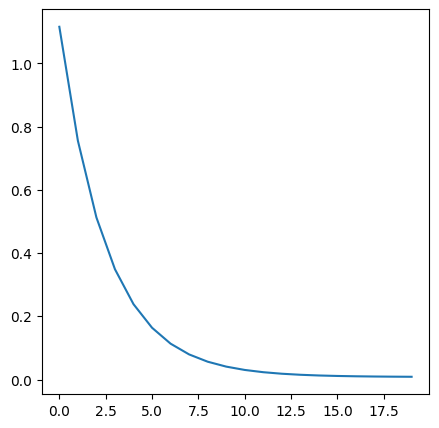

In [259]:
plt.plot(range(20),loss_l)

## None-linear Data

In [180]:
def plot_scatter(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    # plt.axis('off')

    # _m, _c = 0, '.15'
    # plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    # plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_scatter(X, y)

plt.rc('figure', figsize=(5,5), dpi=100)

In [181]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

Shapes: X = (3000, 2), Y = (3000,) 


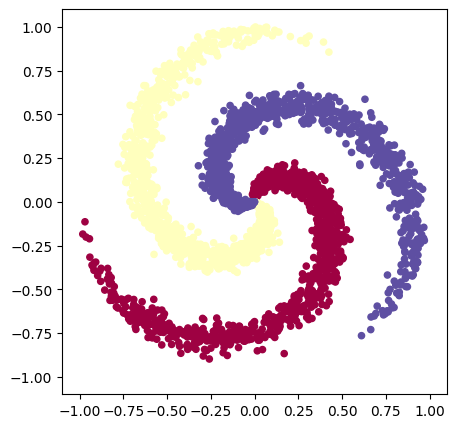

In [182]:
X_cpu = torch.zeros(N * C, D)
y_cpu = torch.zeros(N * C, dtype=torch.long)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    inner_var = torch.linspace((2 * math.pi / C) * (c), 
                               (2 * math.pi / C) * (2 + c), N) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X_cpu[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y_cpu[ix] = c
        index += 1

print(f"Shapes: X = {tuple(X_cpu.size())}, Y = {tuple(y_cpu.size())} ")
plot_scatter(X_cpu, y_cpu)

We now load this data into a Dataset and create a Dataloader

In [194]:
dataset = TensorDataset(X_cpu, y_cpu)
train_loader = DataLoader(dataset, batch_size= 256)

To see why neural networks are powerful, we will first train a completely linear model. 

In [184]:
H = 100

class LinearNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(D, H),
                    nn.Linear(H,C)
                    )

    def forward(self, x):
        output = self.layers(x)
        return output

model = LinearNetwork().to(device)

learning_rate =  1e-3
decay_factor = 1e-5
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay_factor)

for epoch in range(200):
    train(epoch, model, criteria, train_loader, optimizer, device)

Train Epoch: 0 	Loss: 0.914341
Train Epoch: 10 	Loss: 0.626753
Train Epoch: 20 	Loss: 0.568165
Train Epoch: 30 	Loss: 0.558306
Train Epoch: 40 	Loss: 0.558851
Train Epoch: 50 	Loss: 0.561033
Train Epoch: 60 	Loss: 0.562859
Train Epoch: 70 	Loss: 0.564076
Train Epoch: 80 	Loss: 0.564816
Train Epoch: 90 	Loss: 0.565244
Train Epoch: 100 	Loss: 0.565483
Train Epoch: 110 	Loss: 0.565611
Train Epoch: 120 	Loss: 0.565677
Train Epoch: 130 	Loss: 0.565709
Train Epoch: 140 	Loss: 0.565721
Train Epoch: 150 	Loss: 0.565723
Train Epoch: 160 	Loss: 0.565720
Train Epoch: 170 	Loss: 0.565715
Train Epoch: 180 	Loss: 0.565707
Train Epoch: 190 	Loss: 0.565698


During training the loss does not go down much. Plotting the model's region of classification for each class shows that it is only able to create linear classification rules.

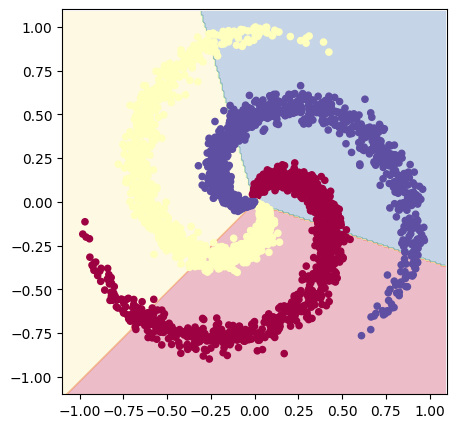

In [185]:
plot_model(X_cpu, y_cpu, model)

We now add a nonlinear activation function, the ReLU and see how the model performs.

In [16]:
dataset = TensorDataset(X_cpu, y_cpu)
train_loader = DataLoader(dataset, batch_size= 256)

H = 100

class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(D, H),
                    nn.ReLU(),
                    nn.Linear(H,C)
                    )

    def forward(self, x):
        output = self.layers(x)
        return output

model = MultiLayerPerceptron().to(device)

learning_rate =  1e-3
decay_factor = 1e-5
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay_factor)

for epoch in range(200):
    train(epoch, model, criteria, train_loader, optimizer, device)

Train Epoch: 0 	Loss: 1.093085
Train Epoch: 10 	Loss: 0.750101
Train Epoch: 20 	Loss: 0.554308
Train Epoch: 30 	Loss: 0.467004
Train Epoch: 40 	Loss: 0.435914
Train Epoch: 50 	Loss: 0.426173
Train Epoch: 60 	Loss: 0.420714
Train Epoch: 70 	Loss: 0.414665
Train Epoch: 80 	Loss: 0.405857
Train Epoch: 90 	Loss: 0.393257
Train Epoch: 100 	Loss: 0.377580
Train Epoch: 110 	Loss: 0.359243
Train Epoch: 120 	Loss: 0.339502
Train Epoch: 130 	Loss: 0.319430
Train Epoch: 140 	Loss: 0.299512
Train Epoch: 150 	Loss: 0.280352
Train Epoch: 160 	Loss: 0.261923
Train Epoch: 170 	Loss: 0.244565
Train Epoch: 180 	Loss: 0.228062
Train Epoch: 190 	Loss: 0.212921


In [17]:
model.eval()
dat = X_cpu[1000].to(device)
_temp = model(dat)
F.softmax(_temp)

/jobfs/92083292.gadi-pbs/ipykernel_2955915/121423793.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(_temp)


tensor([0.3495, 0.3184, 0.3321], grad_fn=<SoftmaxBackward0>)

MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


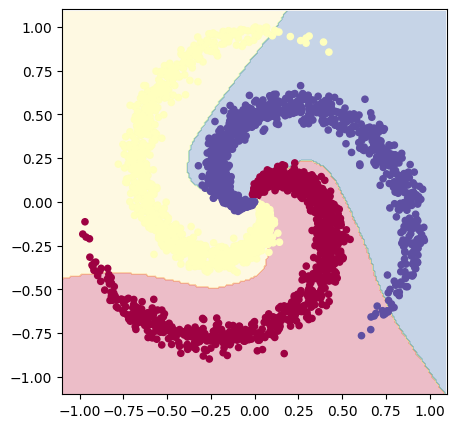

In [18]:
print(model)
plot_model(X_cpu, y_cpu, model)

# Image Classification

We now consider creating a Neural network to run on the classic image classification dataset MNIST. We first load the data

In [21]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

def model_size(model):
    n = 0
    for p in list(model.parameters()):
        n += p.nelement()
    return n

training_data = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_data = datasets.MNIST('./data', train=False, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

input_size = 28 * 28    # image dimensions
output_size = 10        # num classes

13.9%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100.0%
39.7%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%
100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We display a random sample from the dataset below. The images are of handwritten digits and the goal is to classify the digits in the images correctly.

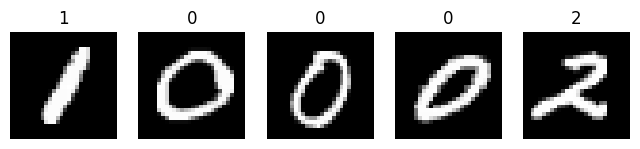

In [22]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [23]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=True)

In [24]:
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # Optimize
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, accuracy_list):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy_list

We can consider a simple Multilayer Perceptron for this task also.

In [25]:
class MLP(nn.Module):
    def __init__(self, input_size, n_feature, output_size) -> None:
        super().__init__()
        self.flatten = nn.Flatten() # flatten 2D tensor into 1D
        self.output = nn.LogSoftmax(dim=1)
        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        out_ = self.output(logits)
        return out_
    


In [26]:
# Training settings 
n_features = 6 # number of feature maps

model = MLP(input_size, n_features, output_size)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(model_size(model)))


accuracy_list = []

for epoch in range(0, 2):
    train(epoch, model)
    accuracy_list = test(model, accuracy_list)

Number of parameters: 669706
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299674
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.999343
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.513131
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.313480
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.213748
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.401386
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.294448
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.406755
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.278406
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.215119

Test set: Average loss: 0.2532, Accuracy: 9240/10000 (92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.254355
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.249516
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.319342
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.190304
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.139598
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.305201
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.256839
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.310973
Train Epoch: 1 [51200/

For image classification, the most standard NN model is called a Convolutional Neural Network (CNN). We provide an implementation of a CNN for MNIST below.

In [27]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [28]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(model_size(model_cnn)))

accuracy_list = []
for epoch in range(0, 2):
    train(epoch, model_cnn)
    test(model_cnn, accuracy_list)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299129
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.716470
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.623807
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.533033
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.404235
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.365059
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.247179
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.327972
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.344461
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.190732

Test set: Average loss: 0.1741, Accuracy: 9455/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.137713
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.197849
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.109777
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.131767
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.049697
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.164287
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.147921
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.133468
Train Epoch: 1 [51200/60